In [56]:
# prepare data
import pandas as pd
# data1 = pd.read_csv("/data/naifanzhang/moe_purning/mmlu/code/results/results_phi_part1.csv")
# data2 = pd.read_csv("/data/naifanzhang/moe_purning/mmlu/code/results/results_phi.csv")
# data = pd.concat([data1,data2])
data1 = pd.read_csv("/data/naifanzhang/moe_purning/mmlu/code/results/results_phi_random.csv")
data2 = pd.read_csv("/data/naifanzhang/moe_purning/mmlu/code/results/results_phi.csv")
data = pd.concat([data1,data2]).reset_index(drop=True)
data.drop_duplicates(inplace=True)
data.to_csv("results_phi.csv", index=False)

data.loc[data.domain=='computer science','domain'] = 'computer_science'


In [57]:
data['label'] = 'baseline'
data['label'][data['mask'].apply(lambda x: 'ours' in x)] = 'ours'
data['label'][data['mask'].apply(lambda x: 'random' in x)] = 'random'
data

# 从mask列中提取数字
import re

def extract_number(mask_str):
    # 使用正则表达式匹配数字
    match = re.search(r'\d+', mask_str)
    if match:
        return int(match.group())
    return None

data['pruning_ratio'] = data['mask'].apply(extract_number)

/tmp/ipykernel_998033/1971835607.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['label'][data['mask'].apply(lambda x: 'ours' in x)] = 'ours'
/tmp/ipykernel_998033/1971835607.py:2: SettingWithCopyWarning: 
A value is trying to be se

In [58]:
data.domain.value_counts()

domain
computer_science    18
law                 18
math                18
physics             18
psychology          18
Name: count, dtype: int64

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_domain_accuracies(data, domains, axes=None, figsize=(24, 4)):
    """
    为多个领域绘制准确率对比图表
    """
    if axes is None:
        fig, axes = plt.subplots(1, 6, figsize=figsize)

    # 存储所有领域的数据用于计算平均值
    all_ours_data = []
    all_baseline_data = []

    def plot_domain_comparison(data, domain, ax, show_ylabel=False, show_legend=False):
        x = [0.375, 0.5, 0.625, 0.75, 0.875, 1]
        domain_data = data[data['domain'] == domain]
        #domain_data = domain_data[domain_data.apply(lambda x: domain in x['mask'], axis=1)].reset_index(drop=True)
        
        # 分别获取ours、baseline和random的数据
        ours_data = domain_data[domain_data['label'] == 'ours'].sort_values('pruning_ratio')
        baseline_data = domain_data[domain_data['label'] == 'baseline'].sort_values('pruning_ratio')
        random_data = domain_data[domain_data['label'] == 'random'].sort_values('pruning_ratio')
        
        # 绘制三条线
        ax.plot(x, ours_data['accuracy'], label='ours', marker='o')
        ax.plot(x, baseline_data['accuracy'], label='baseline', marker='o')
        ax.plot(x, random_data['accuracy'], label='random', marker='o')  # 添加random线
        
        ax.set_xlabel('Parameter Retention Ratio')
        if show_ylabel:
            ax.set_ylabel('Mean Acc')
        ax.set_title(f'{domain}')
        if show_legend:
            ax.legend(title='Method')
        ax.grid(True)
        
        return ours_data, baseline_data, random_data

    # 存储所有领域的数据
    all_ours_data = []
    all_baseline_data = []
    all_random_data = []  # 添加random数据存储

    # 在计算平均值的循环中:
    for domain in domains:
        domain_data = data[data['domain'] == domain]
        #domain_data = domain_data[domain_data.apply(lambda x: domain in x['mask'], axis=1)].reset_index(drop=True)
        
        ours_data = domain_data[domain_data['label'] == 'ours'].sort_values('pruning_ratio')
        baseline_data = domain_data[domain_data['label'] == 'baseline'].sort_values('pruning_ratio')
        random_data = domain_data[domain_data['label'] == 'random'].sort_values('pruning_ratio')
        
        all_ours_data.append(ours_data['accuracy'])
        all_baseline_data.append(baseline_data['accuracy'])
        all_random_data.append(random_data['accuracy'])

    # 绘制Average图表时添加random线
    x = [0.25, 0.375, 0.5, 0.625, 0.75, 1]
    axes[0].plot(x, 
                pd.Series([sum(x) for x in zip(*all_ours_data)]) / len(domains), 
                label='ours', marker='o')
    axes[0].plot(x, 
                pd.Series([sum(x) for x in zip(*all_baseline_data)]) / len(domains), 
                label='baseline', marker='o')
    axes[0].plot(x, 
                pd.Series([sum(x) for x in zip(*all_random_data)]) / len(domains), 
                label='random', marker='o')  # 添加random平均线
    
    axes[0].set_xlabel('Parameter Retention Ratio')
    axes[0].set_ylabel('Mean Acc')  # 只在第一个图显示y轴标签
    axes[0].set_title('Average')
    axes[0].legend(title='Method')  # 只在第一个图显示图例
    axes[0].grid(True)
    # 然后绘制其他领域的图表
    for i, domain in enumerate(domains):
        if i < len(domains):  # 确保不超出axes数量
            plot_domain_comparison(data, domain, axes[i+1], show_ylabel=False, show_legend=False)  # i+1 因为第一个位置已经用于Average

    plt.tight_layout()
    return axes

data_mmlu = data.copy()

# instruct

In [60]:
# prepare data
import pandas as pd
#data1 = pd.read_csv("/data/naifanzhang/moe_purning/Infinity-Instruct/code/results/results_phi_moe_beifen.csv")
data1 = pd.read_csv("/data/naifanzhang/moe_purning/Infinity-Instruct/code/results/results_phi_moe.csv")
data2 = pd.read_csv("/data/naifanzhang/moe_purning/Infinity-Instruct/code/results/results_phi_moe_random.csv")
data = pd.concat([data1,data2]).reset_index(drop=True)
data.drop_duplicates(inplace=True)

data.loc[data.domain=='medical','domain'] = 'medicine'
data['mask'] = data['mask'].str.replace('medical', 'medicine')


In [61]:
data

,mask,domain,mean_perplexity,median_perplexity
0,instructcoding_baseline6,coding,161.021194,11.386626
1,instructcoding_baseline8,coding,46.805404,6.077340
2,instructcoding_baseline10,coding,8.120947,3.275687
3,instructcoding_baseline12,coding,4.143592,2.730427
4,instructcoding_baseline14,coding,3.831725,2.418755
...,...,...,...,...
121,random_mask8,social,23.696994,5.558050
122,random_mask10,social,17.702416,3.795073
123,random_mask12,social,9.495182,2.831808
124,random_mask14,social,7.821049,3.136778


In [62]:
data['label'] = 'baseline'
data['label'][data['mask'].apply(lambda x: 'ours' in x)] = 'ours'
data['label'][data['mask'].apply(lambda x: 'random' in x)] = 'random'
data

# 从mask列中提取数字
import re

def extract_number(mask_str):
    # 使用正则表达式匹配数字
    match = re.search(r'\d+', mask_str)
    if match:
        return int(match.group())
    return None

data['pruning_ratio'] = data['mask'].apply(extract_number)

/tmp/ipykernel_998033/1971835607.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['label'][data['mask'].apply(lambda x: 'ours' in x)] = 'ours'
/tmp/ipykernel_998033/1971835607.py:2: SettingWithCopyWarning: 
A value is trying to be se

In [63]:
data.domain.value_counts()

domain
coding         18
datascience    18
finance        18
math           18
medicine       18
safety         18
social         18
Name: count, dtype: int64

In [64]:
instruct_domain = ['coding','medicine','finance','safety','social']
data = data[data.domain.isin(instruct_domain)].reset_index(drop=True)


In [65]:
def plot_domain_comparisons(data, domains, axes=None, figsize=(24, 4), ylim=(0, 20), x_values=None):
    if x_values is None:
        x_values = [0.375, 0.5, 0.625, 0.75, 0.875, 1]
        
    if axes is None:
        fig, axes = plt.subplots(1, 6, figsize=figsize)
    
    # 存储所有领域的数据用于计算平均值
    all_ours_data = []
    all_baseline_data = []

    def plot_domain_comparison(data, domain, ax, show_ylabel=False):
        domain_data = data[data['domain'] == domain]
        #domain_data = domain_data[domain_data.apply(lambda x: domain in x['mask'], axis=1)].reset_index(drop=True)
        
        # 分别获取ours、baseline和random的数据
        ours_data = domain_data[domain_data['label'] == 'ours'].sort_values('pruning_ratio')
        baseline_data = domain_data[domain_data['label'] == 'baseline'].sort_values('pruning_ratio')
        random_data = domain_data[domain_data['label'] == 'random'].sort_values('pruning_ratio')  # 添加random数据

        ours_perplexity = np.log(ours_data['median_perplexity'])
        baseline_perplexity = np.log(baseline_data['median_perplexity'])
        random_perplexity = np.log(random_data['median_perplexity'])  # 添加random困惑度
        
        # 绘制三条线
        ax.plot(x_values, ours_perplexity, label='ours', marker='o')
        ax.plot(x_values, baseline_perplexity, label='baseline', marker='o')
        ax.plot(x_values, random_perplexity, label='random', marker='o')  # 添加random线
        
        ax.set_xlabel('Parameter Retention Ratio')
        if show_ylabel:  # 只在第一个图显示y轴标签
            ax.set_ylabel('Log Median Perplexity')
        ax.set_title(f'{domain}')
        ax.grid(True)
        
        return ours_data, baseline_data, random_data

    all_ours_data = []
    all_baseline_data = []
    all_random_data = []  # 添加random数据存储
    # 首先计算平均值
    for domain in domains:
        domain_data = data[data['domain'] == domain]
        #domain_data = domain_data[domain_data.apply(lambda x: domain in x['mask'], axis=1)].reset_index(drop=True)
        
        ours_data = domain_data[domain_data['label'] == 'ours'].sort_values('pruning_ratio')
        baseline_data = domain_data[domain_data['label'] == 'baseline'].sort_values('pruning_ratio')
        random_data = domain_data[domain_data['label'] == 'random'].sort_values('pruning_ratio')  # 添加random数据
        
        all_ours_data.append(ours_data['median_perplexity'])
        all_baseline_data.append(baseline_data['median_perplexity'])
        all_random_data.append(random_data['median_perplexity'])  # 添加random数据

    # 绘制Average图表
    axes[0].plot(x_values, 
                pd.Series(np.log([sum(x) for x in zip(*all_ours_data)])) / len(domains), 
                label='ours', marker='o')
    axes[0].plot(x_values, 
                pd.Series(np.log([sum(x) for x in zip(*all_baseline_data)])) / len(domains), 
                label='baseline', marker='o')
    axes[0].plot(x_values, 
                pd.Series(np.log([sum(x) for x in zip(*all_random_data)])) / len(domains), 
                label='random', marker='o')  # 添加random平均线

    axes[0].set_xlabel('Parameter Retention Ratio')
    axes[0].set_ylabel('Log Median Perplexity')  # 只在第一个图显示y轴标签
    axes[0].set_title('Average')
    axes[0].legend(title='Method')
    axes[0].grid(True)

    # 然后绘制其他领域的图表
    for i, domain in enumerate(domains):
        if i < len(domains):  # 确保不超出axes数量
            plot_domain_comparison(data, domain, axes[i+1], show_ylabel=False)  # i+1 因为第一个位置已经用于Average

    plt.tight_layout()
    return axes

data_instruct = data

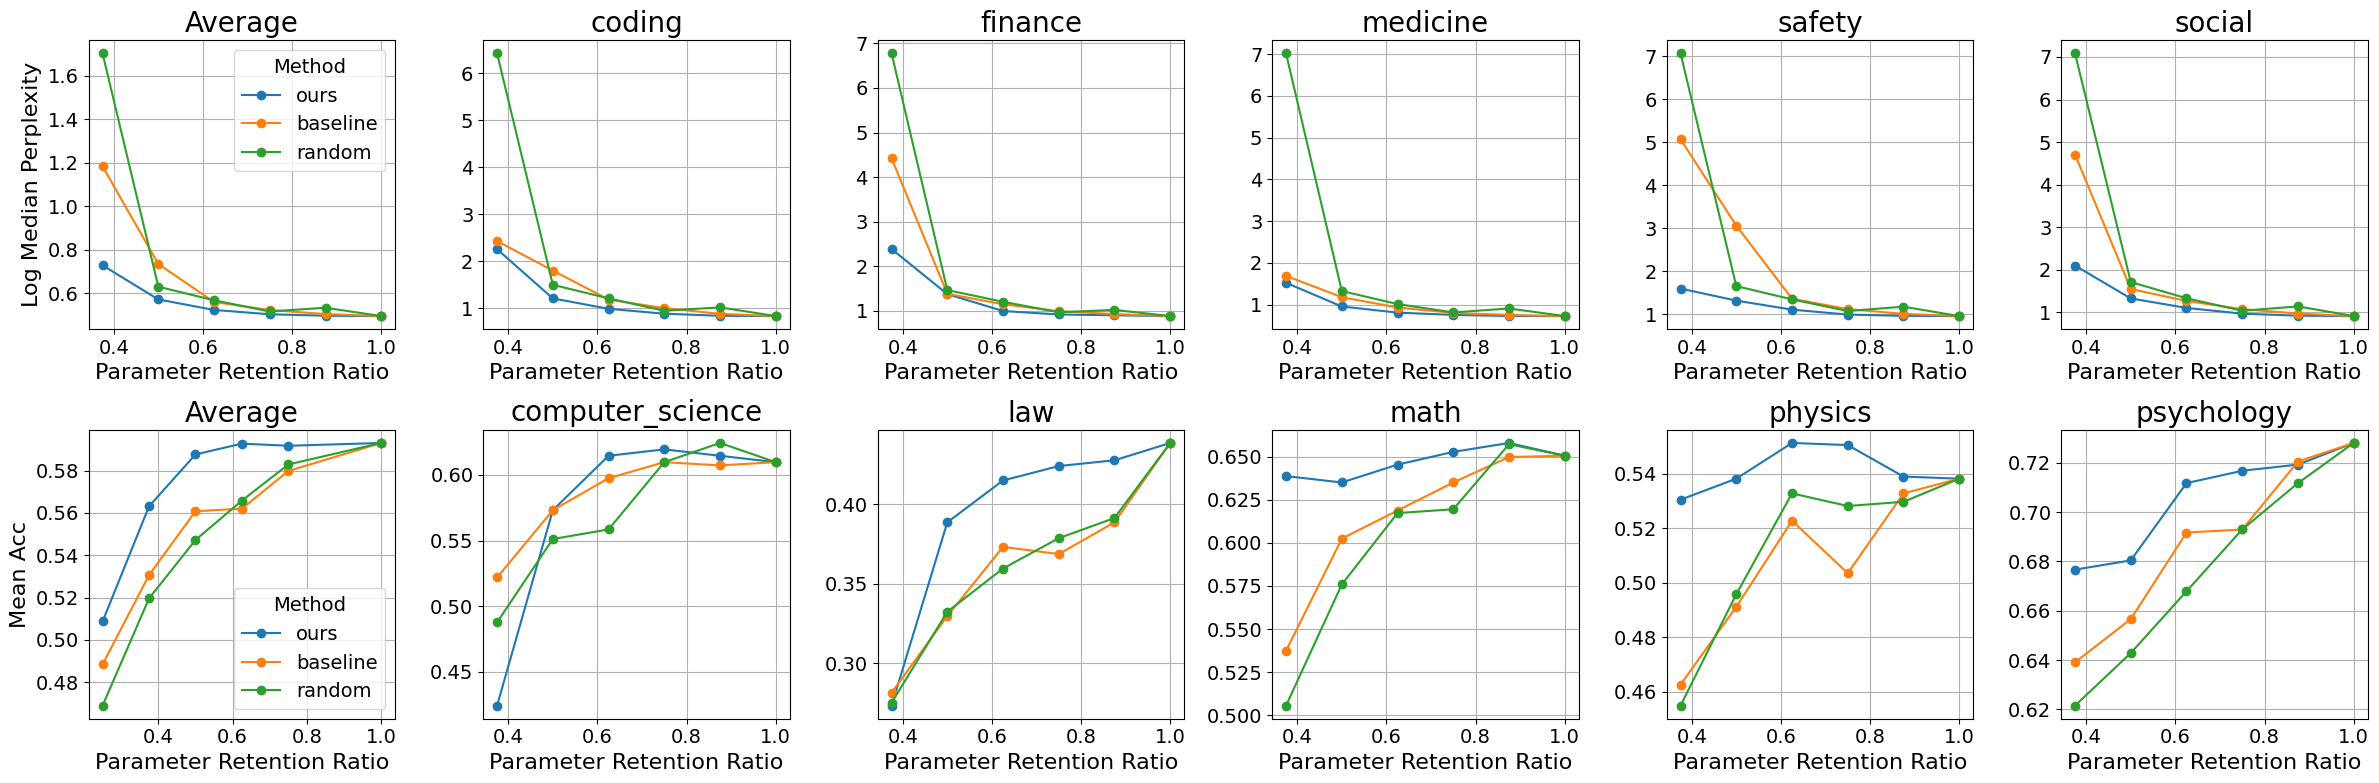

In [66]:
import numpy as np
plt.rcParams.update({'font.size': 14}) 

#data_instruct = data.copy()
domains_isstruct = data_instruct.domain.unique()
#data_mmlu = data.copy()
domains_mmlu = data_mmlu[data_mmlu.domain != 'health'].domain.unique()

# 创建2x6的子图布局
fig, axes = plt.subplots(2, 6, figsize=(24, 8))  # 调整figsize以适应两行

# 第一行: plot_domain_comparisons
plot_domain_comparisons(data_instruct, domains_isstruct, axes=axes[0])

# 第二行: plot_domain_accuracies  
plot_domain_accuracies(data_mmlu, domains_mmlu, axes=axes[1])

# 调整每个子图的字体大小
for ax in axes.flatten():
    # 设置标题字体大小
    ax.set_title(ax.get_title(), fontsize=20)
    
    # 设置x轴和y轴标签字体大小
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    
    # 设置刻度标签字体大小
    ax.tick_params(axis='both', labelsize=14)
    
    # # 设置图例字体大小
    # legend = ax.get_legend()
    # if legend:
    #     legend.set_title(legend.get_title().get_text(), fontsize=14)
    #     for text in legend.get_texts():
    #         text.set_fontsize(12)

# 保存高分辨率图片
plt.savefig('comparison_plot_high_res.png', 
            dpi=1000,              # 设置DPI
            bbox_inches='tight',  # 去除多余的白边
            pad_inches=0.1)       # 设置边距

plt.show()